In [1]:
# Kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# uyarıları kapatalım.
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Veriyi içeri alalım
veri = pd.read_csv("uluslararasi_havayolu_yolculari.csv")
veri.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


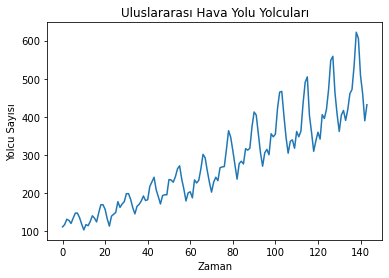

In [5]:
# veriyi görselleştirelim
veri = veri.iloc[:, 1].values
plt.plot(veri)
plt.xlabel("Zaman")
plt.ylabel("Yolcu Sayısı")
plt.title("Uluslararası Hava Yolu Yolcuları")
plt.show()

In [6]:
# verinin şeklini değiştirelim.
veri = veri.reshape(-1, 1)
veri = veri.astype("float32")
veri.shape

(145, 1)

In [7]:
# normalize edelim.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
veri_scaled = scaler.fit_transform(veri)
veri_scaled[:4]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255]], dtype=float32)

In [8]:
# veriyi eğitim ve test olarak bölelim
egitim_boyu = int(len(veri) * 0.60)
test_boyu = len(veri) - egitim_boyu
egitim = veri_scaled[0:egitim_boyu, :]
test = veri_scaled[egitim_boyu:len(veri), :]
print("Eğitim Boyu : {}, Test Boyu : {} ".format(len(egitim), len(test)))

Eğitim Boyu : 87, Test Boyu : 58 


In [9]:
# Eğitim verisini 10'arlı şekillendirelim.
time_stemp = 10
dataX = []
dataY = []
for i in range(len(egitim) - time_stemp - 1):
    a = egitim[i:(i + time_stemp), 0]
    dataX.append(a)
    dataY.append(egitim[i + time_stemp, 0])
egitimX = np.array(dataX)
egitimY = np.array(dataY)

In [10]:
# test verisini 10'arlı şekillendirelim.
dataX = []
dataY = []
for i in range(len(test) - time_stemp - 1):
    a = test[i:(i + time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY)

In [12]:
# veriyi Keras için uygun hale getirelim.
egitimX = np.reshape(egitimX, (egitimX.shape[0], egitimX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print("Eğitim X şekli : ", egitimX.shape)
print("Test X şekli : ", testX.shape)

Eğitim X şekli :  (76, 10, 1)
Test X şekli :  (47, 10, 1)


In [13]:
# Keras kütüphaneleri
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [17]:
# Modelleme
# RNN temelini oluştur
regressor = Sequential()

# ilk katman ve drop out katmanı
regressor.add(SimpleRNN(units = 120, activation = "relu", 
    return_sequences = True, input_shape = (egitimX.shape[1], 1)))
regressor.add(Dropout(0.2))

# İkinci Katman ve drop out Katmanı
regressor.add(SimpleRNN(units = 80, activation = "relu", return_sequences = True))
regressor.add(Dropout(0.2))

# Üçüncü Katman ve drop out Katmanı
regressor.add(SimpleRNN(units = 40, activation = "relu", return_sequences = True))
regressor.add(Dropout(0.2))

# Dördüncü Katman ve drop out Katmanı
regressor.add(SimpleRNN(units = 20, activation = "relu", return_sequences = True))
regressor.add(Dropout(0.2))

# Beşinci Katman ve drop out Katmanı
regressor.add(SimpleRNN(units = 10, activation = "relu", return_sequences = True))
regressor.add(Dropout(0.2))

# tek bir çıktı olacak
regressor.add(Dense(units = 1))

# derleyelim
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

# Eğitim başlasın
regressor.fit(egitimX, egitimY, epochs = 250, batch_size = 50, verbose = 0)


In [19]:
# tahminler
import math
from sklearn.metrics import mean_squared_error

egitimTahmin = regressor.predict(egitimX)
testTahmin = regressor.predict(testX)

# normalize veriyi normale çevirelim.
egitimTahmin = scaler.inverse_transform(egitimTahmin)
egitimY = scaler.inverse_transform([egitimY])
testTahmin = scaler.inverse_transform(testTahmin)
testY = scaler.inverse_transform([testY])

ValueError: Found array with dim 3. Estimator expected <= 2.

In [20]:
# Kök ortalama kare hatası
trainScore = math.sqrt(mean_squared_error(egitimY[0], egitimTahmin[:, 0]))
print("Eğitim Skoru : %.2f RMSE " % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testTahmin[:, 0]))
print("Test Skoru : %.2f RMSE " % (trainScore))

TypeError: Singleton array 0.0 cannot be considered a valid collection.

In [22]:
# Eğitim  verisini kaydıralım
trainPredictPlot = np.empty_like(veri)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(egitimTahmin) + time_stemp, :] = egitimTahmin
# test verisini kaydır
testPredictPlot = np.empty_like(veri)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(egitimTahmin) + (time_stemp * 2) + 1: len(veri) - 1]
# Görselleştir.
plt.plot(scaler.inverse_transform(veri_scaled), color = "b", label = "Gerçek")
plt.plot(trainPredictPlot, color = "r", label = "Egitim")
plt.plot(testPredictPlot, color = "g", label = "Test")
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (76,10,1) into shape (76,1)